In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [6]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [7]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cpu
0.18.0+cpu


In [8]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [44]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.root = root
        self.split = split  # 'train', 'valid', 'test'
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if len(self._load_target(id)) > 0]
        print(f"Loaded {len(self.ids)} images with annotations.")

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        if image is None:
            raise FileNotFoundError(f"Image {path} not found.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)
        
        # Extract boxes and labels in xywh format
        boxes = [t['bbox'] for t in target]
        labels = [t['category_id'] for t in target]
        print(f"Original boxes: {boxes}")
        print(f"Labels: {labels}")

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes, category_ids=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['category_ids']
            print(f"Transformed boxes: {boxes}")

        # Convert boxes from xywh to xyxy format
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        # Prepare the target dictionary
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor(labels, dtype=torch.int64)
        targ['image_id'] = torch.tensor([id], dtype=torch.int64)
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

        return image.div(255.0), targ  # Scale images to [0, 1]

    def __len__(self):
        return len(self.ids)

In [45]:
dataset_path = "Aquarium Combined"

In [46]:
import os

In [7]:
#load classes
dataset_path = "Aquarium Combined"

coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [9]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [49]:
# !pip install albumentations

In [50]:
# !pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensor, ToTensorV2

In [51]:
def get_transforms(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [52]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded 447 images with annotations.


In [53]:
# Lets view a sample
sample = train_dataset
# img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
# plt.imshow(draw_bounding_boxes(
#     img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
# ).permute(1, 2, 0))
sample.root
sample

Dataset AquariumDetection
    Number of datapoints: 447
    Root location: Aquarium Combined
    Compose([
  HorizontalFlip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0}, keypoint_params=None, additional_targets={})

In [57]:
train_dataset

Dataset AquariumDetection
    Number of datapoints: 447
    Root location: Aquarium Combined
    Compose([
  HorizontalFlip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0}, keypoint_params=None, additional_targets={})

In [1]:
import os
import cv2
import copy
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from pycocotools.coco import COCO
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensorV2

class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.root = root
        self.split = split  # 'train', 'valid', 'test'
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if len(self._load_target(id)) > 0]
        print(f"Loaded {len(self.ids)} images with annotations.")

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        if image is None:
            raise FileNotFoundError(f"Image {path} not found.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)
        
        # Extract boxes and labels in xywh format
        boxes = [t['bbox'] for t in target]
        labels = [t['category_id'] for t in target]
        print(f"Original boxes: {boxes}")
        print(f"Labels: {labels}")

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes, category_ids=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['category_ids']
            print(f"Transformed boxes: {boxes}")

        # Convert boxes from xywh to xyxy format
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        # Prepare the target dictionary
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor(labels, dtype=torch.int64)
        targ['image_id'] = torch.tensor([id], dtype=torch.int64)
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

        return image.div(255.0), targ  # Scale images to [0, 1]

    def __len__(self):
        return len(self.ids)

def get_transforms(train=False):
    if train:
        transform = Compose([
            Resize(600, 600),  # our input size can be 600px
            HorizontalFlip(p=0.3),
            VerticalFlip(p=0.3),
            RandomBrightnessContrast(p=0.1),
            ToTensorV2()
        ], bbox_params={'format': 'coco', 'label_fields': ['category_ids']})
    else:
        transform = Compose([
            Resize(600, 600),  # our input size can be 600px
            ToTensorV2()
        ], bbox_params={'format': 'coco', 'label_fields': ['category_ids']})
    return transform

# Usage example
dataset_path = 'dog.jpg'
dataset_path = "Aquarium Combined"

train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

# Test if the dataset works
try:
    image, target = train_dataset[0]
    print(f"Image shape: {image.shape}")
    print(f"Target: {target}")
except Exception as e:
    print(f"Error: {e}")

# Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Iterate through the DataLoader
# for images, targets in train_loader:
#     print(images)
#     print(targets)
#     break


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded 447 images with annotations.
Original boxes: [[0, 752, 176, 243], [126, 738, 431, 184], [10, 845, 202, 133], [490, 486, 208, 123], [665, 265, 102, 55], [541, 933, 226, 90]]
Labels: [2, 2, 2, 2, 2, 2]
Transformed boxes: [(0.0, 440.625, 137.5, 142.3828125), (98.4375, 432.421875, 336.71875, 107.8125), (7.8125, 495.1171875, 157.8125, 77.9296875), (382.8125, 284.765625, 162.5, 72.0703125), (519.53125, 155.2734375, 79.6875, 32.2265625), (422.65625, 546.6796875, 176.5625, 52.734375)]
Image shape: torch.Size([3, 600, 600])
Target: {'boxes': tensor([[  0.0000, 440.6250, 137.5000, 583.0078],
        [ 98.4375, 432.4219, 435.1562, 540.2344],
        [  7.8125, 495.1172, 165.6250, 573.0469],
        [382.8125, 284.7656, 545.3125, 356.8359],
        [519.5312, 155.2734, 599.2188, 187.5000],
        [422.6562, 546.6797, 599.2188, 599.4141]]), 'labels': tensor([2, 2, 2, 2, 2, 2]), 'image_id': tensor([0]), 'area'

Original boxes: [[91, 392, 480, 431], [67, 332, 60, 65], [615, 117, 140, 70]]
Labels: [4, 4, 4]
Transformed boxes: [(153.90624999999997, 117.7734375, 375.0, 252.5390625), (500.78125, 367.3828125, 46.875, 38.0859375), (10.156250000000021, 490.4296875, 109.37499999999997, 41.015625)]


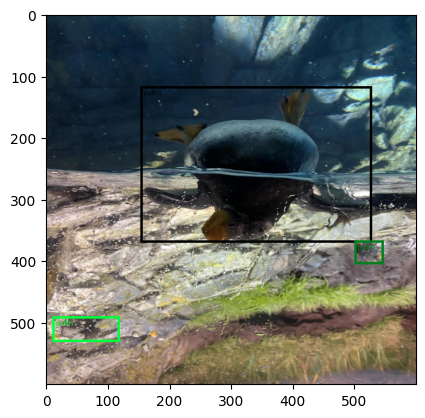

In [10]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [11]:
len(train_dataset)

447

In [12]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\Rahul/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:21<00:00, 3.56MB/s]


In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [15]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, epoch)
#     lr_scheduler.step()

In [ ]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

In [ ]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model()
    pred = prediction[0]

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))